# S2S RNN to predict next state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data

from Process_Training_Data import norm
from Process_Training_Data import class_to_action
from Process_Training_Data import closest_category

importing Jupyter notebook from Process_Training_Data.ipynb
Empty DataFrame
Columns: [id_camino, D0, D1, D2, D3, D4, D5, out_action, A0, A1]
Index: []


### Get the data
First Import it using pandas

In [5]:
dataset_short = Process_Training_Data.get_data("./data/fromStateToAction_df (28) last.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data.normalize_data(dataset_short,action_vector)

N_STEPS = 3
position = "post"
dataset2 = Process_Training_Data.padding(normed_dataset,N_STEPS,position)

In [6]:
normed_dataset["id_camino"].unique()

array([   0,    1,    2, ..., 1328, 1329, 1330], dtype=int64)

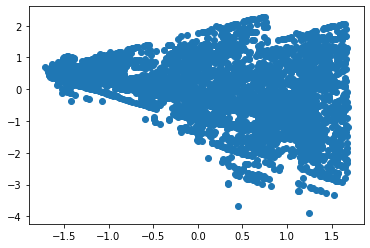

In [7]:
plt.scatter(normed_dataset["D0"], normed_dataset["D1"])

(array([ 33., 112., 134., 137., 137., 127.,  96.,  79.,  93.,  95.,  93.,
         74.,  99.,  84.,  70.,  67.,  78.,  80.,  68.,  37.,  50.,  62.,
         79.,  93., 116., 102.,  84., 101.,  86., 111., 126.,  89., 108.,
        101.,  84., 112., 111., 107.,  91.,  70.,  77.,  77., 141., 158.,
        148.,  82.,  84.,  73.,  78.,  79.]),
 array([-1.71142981, -1.64362549, -1.57582118, -1.50801686, -1.44021255,
        -1.37240823, -1.30460392, -1.2367996 , -1.16899528, -1.10119097,
        -1.03338665, -0.96558234, -0.89777802, -0.8299737 , -0.76216939,
        -0.69436507, -0.62656076, -0.55875644, -0.49095212, -0.42314781,
        -0.35534349, -0.28753918, -0.21973486, -0.15193054, -0.08412623,
        -0.01632191,  0.0514824 ,  0.11928672,  0.18709104,  0.25489535,
         0.32269967,  0.39050398,  0.4583083 ,  0.52611261,  0.59391693,
         0.66172125,  0.72952556,  0.79732988,  0.86513419,  0.93293851,
         1.00074283,  1.06854714,  1.13635146,  1.20415577,  1.27196009,
 

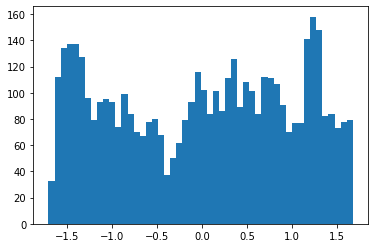

In [8]:
plt.hist(normed_dataset["D0"], bins=50)

(array([  2.,   1.,  11.,  51.,  48.,  83., 126., 166., 198., 246., 291.,
        349., 541., 867., 777., 336., 299., 136., 104.,  41.]),
 array([-3.90791018, -3.59832437, -3.28873855, -2.97915274, -2.66956693,
        -2.35998111, -2.0503953 , -1.74080948, -1.43122367, -1.12163786,
        -0.81205204, -0.50246623, -0.19288041,  0.1167054 ,  0.42629121,
         0.73587703,  1.04546284,  1.35504866,  1.66463447,  1.97422029,
         2.2838061 ]),
 <a list of 20 Patch objects>)

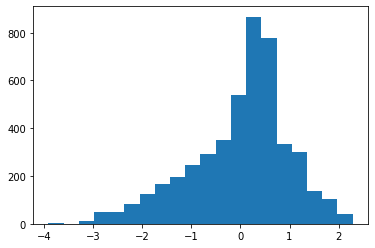

In [9]:
plt.hist(normed_dataset["D1"], bins=20)

(array([8.000e+00, 1.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.400e+01,
        2.300e+01, 1.700e+01, 2.600e+01, 3.200e+01, 3.400e+01, 4.500e+01,
        4.300e+01, 8.700e+01, 5.400e+01, 5.300e+01, 5.400e+01, 8.700e+01,
        1.010e+02, 9.700e+01, 1.220e+02, 1.430e+02, 1.620e+02, 1.920e+02,
        1.900e+02, 2.380e+02, 4.610e+02, 1.032e+03, 2.250e+02, 2.020e+02,
        1.510e+02, 1.270e+02, 2.300e+02, 3.900e+01, 6.800e+01, 1.240e+02,
        1.200e+02, 8.700e+01, 1.600e+02, 1.250e+02, 8.800e+01, 6.800e+01,
        4.700e+01, 5.100e+01, 4.200e+01, 1.700e+01, 3.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00]),
 array([-3.2127523 , -3.09478787, -2.97682344, -2.85885901, -2.74089459,
        -2.62293016, -2.50496573, -2.3870013 , -2.26903687, -2.15107244,
        -2.03310801, -1.91514359, -1.79717916, -1.67921473, -1.5612503 ,
        -1.44328587, -1.32532144, -1.20735701, -1.08939258, -0.97142816,
        -0.85346373, -0.7354993 , -0.61753487, -0.49957044, -0.38160601,
        -0.

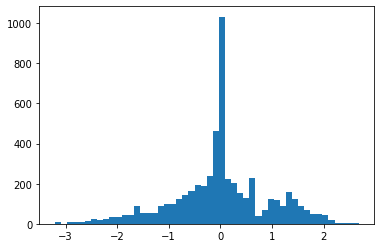

In [10]:
plt.hist(dataset2[:,:,3].flatten(), bins=50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 2.100e+01,
        1.800e+01, 1.500e+01, 2.900e+01, 2.200e+01, 4.300e+01, 6.800e+01,
        8.100e+01, 7.200e+01, 1.250e+02, 2.610e+02, 3.930e+02, 5.340e+02,
        1.537e+03, 6.760e+02, 3.880e+02, 3.470e+02, 2.320e+02, 1.330e+02,
        1.090e+02, 5.300e+01, 3.400e+01, 2.400e+01, 1.200e+01, 4.000e+00,
        5.000e+00, 9.000e+00, 3.600e+01, 2.000e+00, 5.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([-6.08252118, -5.83717356, -5.59182595, -5.34647833, -5.10113071,
        -4.8557831 , -4.61043548, -4.36508786, -4.11974025, -3.87439263,
        -3.62904501, -3.3836974 , -3.13834978, -2.89300216, -2.64765455,
        -2.40230693, -2.15695932, -1.9116117 , -1.66626408, -1.42091647,
        -1.17556885, -0.93022123, -0.68487362, -0.439526  , -0.19417838,
         0.

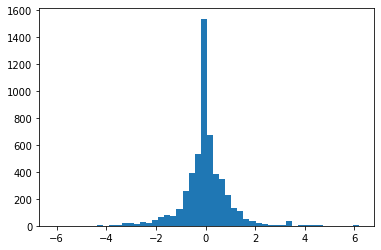

In [11]:
plt.hist(dataset2[:,:,4].flatten(), bins=50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 2.100e+01,
        1.800e+01, 1.500e+01, 2.900e+01, 2.200e+01, 4.300e+01, 6.800e+01,
        8.100e+01, 7.200e+01, 1.250e+02, 2.610e+02, 3.930e+02, 5.340e+02,
        1.537e+03, 6.760e+02, 3.880e+02, 3.470e+02, 2.320e+02, 1.330e+02,
        1.090e+02, 5.300e+01, 3.400e+01, 2.400e+01, 1.200e+01, 4.000e+00,
        5.000e+00, 9.000e+00, 3.600e+01, 2.000e+00, 5.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([-6.08252118, -5.83717356, -5.59182595, -5.34647833, -5.10113071,
        -4.8557831 , -4.61043548, -4.36508786, -4.11974025, -3.87439263,
        -3.62904501, -3.3836974 , -3.13834978, -2.89300216, -2.64765455,
        -2.40230693, -2.15695932, -1.9116117 , -1.66626408, -1.42091647,
        -1.17556885, -0.93022123, -0.68487362, -0.439526  , -0.19417838,
         0.

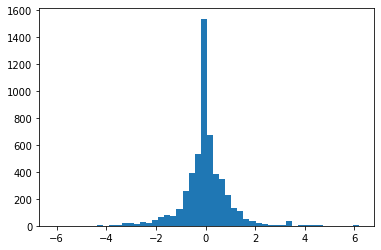

In [12]:
plt.hist(dataset2[:,:,4].flatten(), bins=50)

(array([3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        1.600e+01, 1.700e+01, 3.100e+01, 5.200e+01, 6.600e+01, 6.200e+01,
        5.400e+01, 4.400e+01, 3.900e+01, 8.500e+01, 6.800e+01, 7.000e+01,
        1.040e+02, 1.190e+02, 2.180e+02, 5.040e+02, 1.135e+03, 2.890e+02,
        8.540e+02, 1.230e+02, 1.010e+02, 8.900e+01, 9.500e+01, 8.700e+01,
        1.350e+02, 8.900e+01, 1.070e+02, 1.350e+02, 1.040e+02, 6.900e+01,
        8.800e+01, 6.300e+01, 4.300e+01, 3.600e+01, 3.400e+01, 2.800e+01,
        2.200e+01, 1.300e+01, 1.900e+01, 4.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-3.36352012, -3.22421436, -3.0849086 , -2.94560283, -2.80629707,
        -2.66699131, -2.52768554, -2.38837978, -2.24907402, -2.10976826,
        -1.97046249, -1.83115673, -1.69185097, -1.55254521, -1.41323944,
        -1.27393368, -1.13462792, -0.99532215, -0.85601639, -0.71671063,
        -0.57740487, -0.4380991 , -0.29879334, -0.15948758, -0.02018182,
         0.

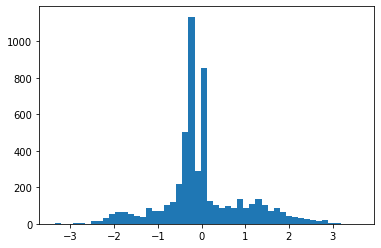

In [13]:
plt.hist(dataset2[:,:,5].flatten(), bins=50)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [15]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [16]:
x_train_single_sequential[0]

array([[ 1.59717363, -1.70102178,  0.6942984 ,  1.1497174 , -0.15136753,
        -0.27057772],
       [ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792]])

In [17]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (3, 6)


In [18]:
y_train_single_sequential[0]

array([[-0.01745,  0.     ],
       [-0.05236,  0.     ],
       [-0.05236,  0.     ]])

In [19]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [20]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.Masking(mask_value = 0,input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True))
single_step_sequential_model.add(tf.keras.layers.Dense(12, activation="relu"))
single_step_sequential_model.add(tf.keras.layers.Dense(12, activation="relu"))
single_step_sequential_model.add(tf.keras.layers.Dense(12, activation="relu"))
single_step_sequential_model.add(tf.keras.layers.Dense(12, activation="relu"))
single_step_sequential_model.add(tf.keras.layers.Dense(12, activation="relu"))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mse','mae'])

### Inspect the model

In [21]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 6)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 11)          792       
_________________________________________________________________
dense (Dense)                (None, None, 12)          144       
_________________________________________________________________
dense_1 (Dense)              (None, None, 12)          156       
_________________________________________________________________
dense_2 (Dense)              (None, None, 12)          156       
_________________________________________________________________
dense_3 (Dense)              (None, None, 12)          156       
_________________________________________________________________
dense_4 (Dense)              (None, None, 12)          1

### Train the model

In [22]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 53.2 steps, validate for 50 steps
Epoch 1/20
54/53 [==============================] - 13s 244ms/step - loss: 0.0363 - mse: 0.0038 - mae: 0.0368 - val_loss: 0.0372 - val_mse: 0.0039 - val_mae: 0.0378
Epoch 2/20
54/53 [==============================] - 1s 10ms/step - loss: 0.0315 - mse: 0.0028 - mae: 0.0319 - val_loss: 0.0307 - val_mse: 0.0022 - val_mae: 0.0308
Epoch 3/20
54/53 [==============================] - 0s 9ms/step - loss: 0.0254 - mse: 0.0018 - mae: 0.0258 - val_loss: 0.0256 - val_mse: 0.0017 - val_mae: 0.0254
Epoch 4/20
54/53 [==============================] - 1s 10ms/step - loss: 0.0228 - mse: 0.0016 - mae: 0.0231 - val_loss: 0.0239 - val_mse: 0.0015 - val_mae: 0.0238
Epoch 5/20
54/53 [==============================] - 1s 11ms/step - loss: 0.0213 - mse: 0.0015 - mae: 0.0216 - val_loss: 0.0224 - val_mse: 0.0014 - val_mae: 0.0223
Epoch 6/20
54/53 [==============================] - 1s 14ms/step - loss: 0.0200 - mse: 0.0014 - mae: 0.0203 - val_loss: 0.0229 - val_mse: 0.

Compute the accuracy

In [23]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [24]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

0.40449437


In [25]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

267/267 - 3s - loss: 0.0185 - mse: 0.0012 - mae: 0.0186


Visualize the model's training progress.

In [26]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

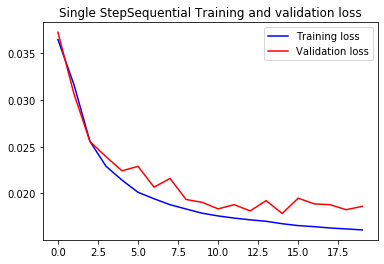

In [27]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0159,  mae:0.0161,  mse:0.0011,  val_loss:0.0179,  val_mae:0.0178,  val_mse:0.0012,  
....................

In [29]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.56554306


In [30]:
single_step_sequential_model.save('./data/S2S_S2A_model.h5') 